# Teoria da Decisão - ELE088

*Alunos:*  

*Guilherme Fachinelli*

*Rafael Campello Soares*

*Stéphanie Barbosa*  

*Universidade Federal de Minas Gerais* 

In [ ]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x


In [204]:
# Leitura dos dados
path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

custo_por_plano = Planos.set_index("ID")["custo"].to_dict()
'''
print("Equipamentos:")
print(Equipamentos.head(), "\n")
print("Planos de Manutenção:")
print(Planos.head(), "\n")
print("Modelos de Falha (Weibull):")
print(ModeloFalha.head())
'''


'\nprint("Equipamentos:")\nprint(Equipamentos.head(), "\n")\nprint("Planos de Manutenção:")\nprint(Planos.head(), "\n")\nprint("Modelos de Falha (Weibull):")\nprint(ModeloFalha.head())\n'

In [205]:
#Solução inicial aleatoria

def Sol_Inicial(equipamentos):
    return np.random.randint(2, 3, size=len(equipamentos))

solucao_padrao = Sol_Inicial(Equipamentos)
'''
print("Primeiros 10 planos atribuídos:", solucao_padrao[:10])
print("Distribuição dos planos:", dict(zip(*np.unique(solucao_padrao, return_counts=True))))
'''

'\nprint("Primeiros 10 planos atribuídos:", solucao_padrao[:10])\nprint("Distribuição dos planos:", dict(zip(*np.unique(solucao_padrao, return_counts=True))))\n'

In [206]:
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados


In [207]:
def fobj_f1(x, dados):
    custo_total = sum(dados.custo_por_plano[plano] for plano in x.solution)
    x.fitness = custo_total
    return x

In [208]:
def fobj_f2(x, dados):
    custo_total = 0
    for i, plano in enumerate(x.solution):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq["cluster"]]
        plano_info = dados.planos.loc[plano]

        t0 = eq["t0"]
        k = plano_info["k"]
        delta_t = 5
        eta = cluster["eta"]
        beta = cluster["beta"]

        Fi = lambda t: 1 - np.exp(-(t / eta)**beta)
        pi = (Fi(t0 + k * delta_t) - Fi(t0)) / (1 - Fi(t0))
        custo_total += pi * eq["custo de falha"]

    x.fitness = custo_total
    return x


In [209]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):
    if y.fitness < x.fitness:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
    return x, k


In [210]:
'''
Implementa a função shake
'''
def shake(x, k, planos=3):
    y = copy.deepcopy(x)
    indices = np.random.permutation(len(x.solution))[:k]
    for idx in indices:
        plano_atual = y.solution[idx]
        opcoes = [p for p in range(1, planos+1) if p != plano_atual]
        y.solution[idx] = np.random.choice(opcoes)
    return y

### Estrutura principal do método RVNS

In [211]:
# -------------------------------
# RVNS PARA O PROBLEMA DE MANUTENÇÃO
# -------------------------------

def rvns(fobj, sol_inicial, shake, max_num_sol_avaliadas=10000, kmax=3):
    x = wrap_struct(sol_inicial())
    x = fobj(x)
    num_sol_avaliadas = 1
    historico = []
    historico.append(x.fitness)
    best = copy.deepcopy(x)
    historico_best = []
    historico_best.append(best.fitness)

    while num_sol_avaliadas < max_num_sol_avaliadas:
        k = 1
        while k <= kmax:
            y = shake(x, k)
            y = fobj(y)
            num_sol_avaliadas += 1

            if y.fitness < x.fitness:
                x = copy.deepcopy(y)
                k = 1
            else:
                k += 1

            if x.fitness < best.fitness:
                best = copy.deepcopy(x)

            historico.append(x.fitness)
            historico_best.append(best.fitness)

    print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
    print('x = {}\n'.format(historico[0]))
    print('fitness(x) = {:.2f}\n'.format(historico[0]))

    print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
    print('x = {}\n'.format(best.solution))
    print('fitness(x) = {:.2f}\n'.format(best.fitness))

    plt.figure(figsize=(10, 6))
    plt.plot(historico, label='fitness atual')
    plt.plot(historico_best, label='melhor fitness até agora', linestyle='--')
    plt.title("Evolução da qualidade da solução")
    plt.xlabel("Iterações")
    plt.ylabel("fitness(x)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return best, historico


--- SOLUÇÃO INICIAL CONSTRUÍDA ---

x = 1435.000741604621

fitness(x) = 1435.00


--- MELHOR SOLUÇÃO ENCONTRADA ---

x = [3 3 3 3 2 3 2 3 3 2 3 2 2 3 3 3 2 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 2 3 2 2
 3 3 3 3 3 3 2 3 3 3 3 2 3 3 3 2 2 2 3 3 3 2 1 2 2 1 3 3 3 3 3 3 3 3 1 3 3
 3 1 2 1 3 3 2 3 3 2 1 3 3 2 1 3 3 3 3 2 3 3 3 2 3 3 2 3 3 2 3 2 3 3 3 2 3
 2 3 2 2 3 2 3 3 2 3 3 2 3 3 2 2 2 3 1 1 1 3 3 1 2 3 3 3 3 2 2 2 3 3 3 3 3
 3 3 3 3 2 2 3 2 3 3 3 3 3 2 3 2 3 2 2 2 2 2 2 3 2 3 3 2 3 3 3 3 3 3 3 2 3
 3 2 3 2 3 3 3 2 2 2 2 3 1 2 3 3 3 1 3 2 3 3 3 3 3 3 2 3 3 3 3 2 2 2 2 2 2
 2 3 3 2 3 3 3 3 3 2 3 3 2 3 2 1 2 2 3 3 2 3 3 3 2 2 3 3 2 3 2 3 3 3 3 3 3
 2 2 3 3 2 3 3 3 3 3 2 3 2 2 3 3 3 2 2 3 3 2 3 2 3 3 3 3 3 3 2 3 2 2 2 3 2
 3 3 2 1 3 2 3 3 3 2 2 2 3 2 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 2 3 3 2 2 2 3 3
 2 3 3 2 1 2 3 3 3 3 3 2 3 3 2 3 2 3 3 2 3 2 3 3 3 3 3 2 2 3 3 3 3 2 3 2 2
 2 3 2 2 2 3 3 3 2 2 3 3 3 2 3 3 3 3 2 1 3 2 3 2 3 3 2 3 3 3 3 3 3 3 3 3 3
 2 3 3 3 3 2 3 2 3 2 3 3 3 2 1 2 3 2 2 3 3 3 3 3 2 2 

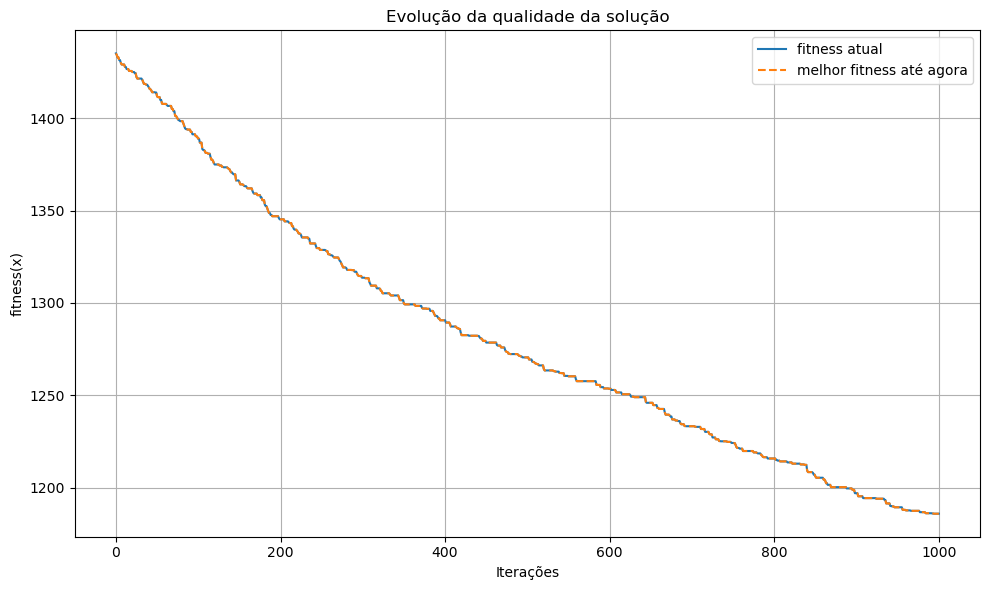

In [212]:

dados = manutencao_def(Equipamentos, Planos)

best, historico = rvns(
    fobj=lambda x: fobj_f2(x, dados), #troque entre fobj_f1 e fobj_f2 rodar f1 ou f2
    sol_inicial=lambda: Sol_Inicial(Equipamentos),
    shake=shake,
    max_num_sol_avaliadas=1000,
    kmax=3
) 